#Senior Vision Researcher Exercise
## Download kaggle coco dataset

In [17]:
!pip install kaggle --quiet

# Download the dataset
!kaggle datasets download -d ultralytics/coco128

# Unzip the dataset
!unzip -qq coco128.zip

# copy the images and removing the rest
!mkdir images
!mv coco128/images/train2017/*.jpg images/
!rm -rf coco128*

Dataset URL: https://www.kaggle.com/datasets/ultralytics/coco128
License(s): GNU Affero General Public License 3.0
  0% 0.00/6.66M [00:00<?, ?B/s]
100% 6.66M/6.66M [00:00<00:00, 90.7MB/s]
mkdir: cannot create directory ‘images’: File exists


## Install python packages

In [18]:
!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet

  Preparing metadata (setup.py) ... done


## Part 1
#### The main code

In [19]:
# Import necessary libraries
import torch
import torch.nn as nn
import clip  # OpenAI's CLIP model for image and text embedding
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader
from glob import glob
import matplotlib.pyplot as plt

# Custom dataset class to handle image data
class MyDataset(Dataset):
    def __init__(self, images, labels=None, preprocess=None):
        """
        Initialize the dataset with images, optional labels, and preprocessing function.
        :param images: List of images (numpy arrays)
        :param labels: Optional list of labels
        :param preprocess: Optional preprocessing function (e.g., CLIP preprocessing)
        """
        self.images = images
        self.label = labels
        self.preprocess = preprocess

    def __len__(self):
        """
        Return the number of images in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Fetch the image and label at the specified index.
        :param idx: Index of the image to retrieve
        :return: Tuple of (image, label)
        """
        image = self.images[idx]
        label = self.label[idx] if self.label is not None else -1
        image = Image.fromarray(image)  # Convert the image to PIL format
        if self.preprocess is not None:
            image = self.preprocess(image)  # Apply preprocessing if provided

        return image, label

# Class to handle tagging with CLIP model based on provided tags
class Tagger():
    def __init__(self, tag_dict):
        """
        Initialize the Tagger with tag dictionary and CLIP model.
        :param tag_dict: Dictionary of tags organized by category
        """
        self.tag_dict = tag_dict
        # Select device based on GPU availability
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Load CLIP model and its preprocessing function
        self.clip_model, self.im_preprocess = clip.load("ViT-B/32", device=self.device)
        # Calculate and store text features for each tag category
        self.text_features = {
            cat: nn.Parameter(tags) for cat, tags in self.get_text_features(tag_dict).items()}

    def get_text_features(self, tag_dict):
        """
        Convert tags to text embeddings using the CLIP model.
        :param tag_dict: Dictionary of tags categorized by type
        :return: Dictionary with category keys and tensor embeddings
        """
        text_features = {}
        with torch.no_grad():
            for category, tags in tag_dict.items():
                # Create descriptive text for each tag
                tag_texts = [f"This image is {tag}" for tag in tags]
                # Tokenize and encode text with CLIP to generate text embeddings
                text_tokens = clip.tokenize(tag_texts).to(self.device)
                text_features[category] = self.clip_model.encode_text(text_tokens).clone().detach().float()

        return text_features

    def create_dataloader(self, images, labels=None):
        """
        Create a DataLoader for batching images.
        :param images: List of images
        :param labels: Optional list of labels
        :return: DataLoader for batched image processing
        """
        dataset = MyDataset(images, labels=labels, preprocess=self.im_preprocess)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
        return dataloader

    def __call__(self, np_images, threshold=0.23, max_only=True):
        """
        Perform tagging on input images based on similarity to text embeddings.
        :param np_images: List of images in numpy array format
        :param threshold: Minimum similarity score to consider a match
        :param max_only: Whether to consider only the highest score per category
        :return: List of dictionaries with tagging results per image
        """
        # Create DataLoader for input images
        dataloader = self.create_dataloader(np_images)
        resutls = []

        # Process each batch in the DataLoader
        for images, _ in dataloader:
            batch_results = [{} for _ in images]
            with torch.no_grad():
                # Encode images into CLIP image embeddings
                image_features = self.clip_model.encode_image(images.to(self.device)).float()

                # Compare image embeddings to each category's text embeddings
                for category, embedding in self.text_features.items():
                    embedding = embedding.to(self.device)
                    similarity = (image_features @ embedding.T).softmax(dim=-1)

                    # If max_only is true, only save the highest scoring tag above the threshold
                    if max_only:
                        max_vals, max_indices = torch.max(similarity, dim=1)
                        for im_idx, (max_val, max_ind) in enumerate(zip(max_vals, max_indices)):
                            if max_val > threshold:
                                batch_results[im_idx][category] = {
                                    "tag": self.tag_dict[category][max_ind],
                                    "score": max_val.item(),
                                    "index": max_ind.item()}
                    else:
                        # Store all tags above threshold in the batch results
                        for im_idx, similarities in enumerate(similarity):
                            for tag_idx, similarity in enumerate(similarities):
                                if similarity > threshold:
                                    batch_results[im_idx][category] = {
                                        "tag": self.tag_dict[category][tag_idx],
                                        "score": similarity.item(),
                                        "index": tag_idx}

            resutls.extend(batch_results)  # Append batch results to final results
        return resutls


### Test Part 1

In [20]:
# Sample tag dictionary and dummy data
tag_dict = {
    "Animals": [
        "dog", "cat", "elephant", "giraffe", "bird", "bear", "zebra", "lizard",
        "horse", "stuffed animals", "fish", "butterfly"
    ],
    "Sports": [
        "baseball", "tennis", "soccer", "snowboard", "skiing", "skateboarding",
        "flying", "kite", "swimming"
    ],
    "Living Beings": [
        "animals", "people", "children", "man", "woman"
    ],
    "Activities & Actions": [
        "sports", "playing", "eating", "drinking", "sitting", "standing",
        "walking", "riding", "sleeping"
    ],
    "Food": [
        "drink", "pizza", "cake", "sandwich"
    ],
    "Drink": [
        "coffee", "juice", "wine"
    ],
    "Places": [
        "natural settings", "urban", "beach", "field", "park", "river",
        "city", "street", "house", "room", "kitchen"
    ],
    "Objects": [
        "furniture", "vehicles", "electronics", "sports equipment", "clock",
        "table", "chair", "couch", "bed", "bicycle", "car"
    ],
    "Nature & Weather": [
        "nature", "trees", "flowers", "grass", "sunset", "snow", "sunny", "cloudy"
    ],
    "Colors": [
        "red", "white", "yellow", "green", "blue"
    ],
    "Time & Season": [
        "morning", "afternoon", "night", "seasonal", "summer", "winter"
    ],
    "Location": [
        "indoor", "outdoor"
    ]
}

images = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in glob("images/*.jpg")]
tagger = Tagger(tag_dict)
tags_part1 = tagger(images, threshold=0.9)

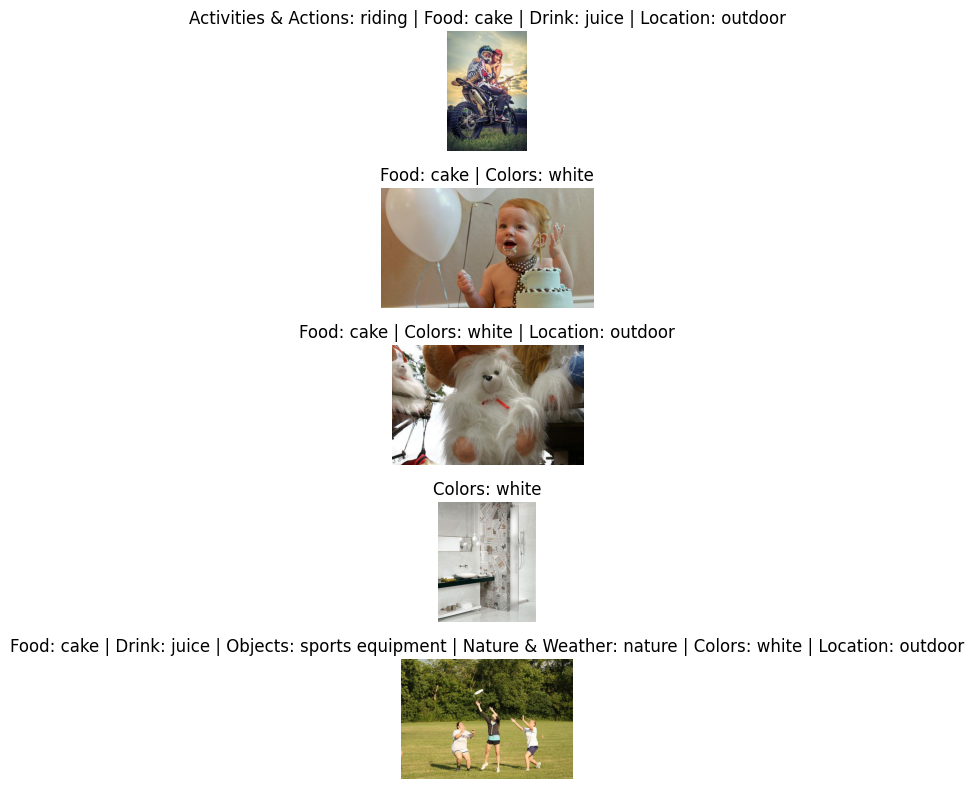

In [21]:
# Define the number of rows and columns for the plot grid
rows = 5
cols = 1

# Create a figure with a specified grid layout and figure size
fig, axs = plt.subplots(rows, cols, figsize=(15, 8))

# Loop through the first 5 images and their associated tags
for i in range(5):
    # Retrieve the image and the tags for the current index
    image = images[i]
    tags = tags_part1[i]

    # Extract only the tag names from the tags dictionary for display
    tags = {category: tag["tag"] for category, tag in tags.items()}

    # Create a title by joining categories and tags as strings, separated by "|"
    title = " | ".join([f"{category}: {tag}" for category, tag in tags.items()])

    # Display the image in the subplot and set the title with tag information
    axs[i].imshow(image)
    axs[i].set_title(title)
    axs[i].axis('off')  # Hide axes for a cleaner look

# Adjust layout to avoid overlapping and display the plot
plt.tight_layout()
plt.show()


## Part 2 - Optimize the tagger
### support code  

In [22]:
def optimize_model(tagger, images, labels, lr=0.01, epochs=5, print_ever=1):
    """
    Optimize the tagger model by fine-tuning text embeddings for image tagging.
    :param tagger: Tagger object containing CLIP model and text features
    :param images: List of images to train on
    :param labels: Corresponding labels for each image
    :param lr: Learning rate for the optimizer
    :param epochs: Number of training epochs
    :param print_ever: Frequency (in epochs) to print the loss
    """
    # Set device and model parameters from the tagger
    device = tagger.device
    model = tagger.text_features  # Retrieve text features as model parameters

    # Initialize optimizer and loss criterion
    optimizer = torch.optim.AdamW(model.values(), lr=lr)  # Use AdamW optimizer
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)  # Cross-entropy loss, ignoring index -1

    # Create DataLoader for batching images and labels
    dataloader = tagger.create_dataloader(images, labels)
    for epoch in range(epochs):
        epoch_loss = 0.0  # Track epoch loss for printing
        for t_images, t_labels in dataloader:
            optimizer.zero_grad()  # Reset gradients for the optimizer
            total_loss = 0  # Initialize total loss for batch

            # Encode images into feature embeddings using CLIP model
            image_features = tagger.clip_model.encode_image(t_images.to(device)).float()

            # Calculate similarity and loss for each category
            for category, embedding in model.items():
                embedding = embedding.to(device)  # Move embeddings to device
                # Calculate similarity between image features and text embeddings
                similarity = (image_features @ embedding.T).softmax(dim=-1)
                # Compute loss for the current category's similarity scores and labels
                loss = criterion(similarity, t_labels[category].to(device))
                total_loss += loss  # Accumulate loss for all categories

            # Print the loss at specified intervals
            if epoch % print_ever == 0:
                print(f"Epoch: {epoch}, Loss: {total_loss.item()}")

            # Backpropagate loss and update model parameters
            total_loss.backward()
            optimizer.step()


In [23]:
def create_labels(tagger, images, threshold=0.6):
    """
    Generate labels for images by using the tagger to identify relevant tags above a score threshold.
    This threshold helps filter out low-confidence tags to avoid adding noise.

    :param tagger: Tagger object for generating tags and scores for images
    :param images: List of images to generate labels for
    :param threshold: Minimum score threshold to consider a label valid
    :return: List of dictionaries with labels above the threshold, with noise reduced by marking low scores as -1
    """

    # Initialize the tagger with the provided tag dictionary (assuming 'tag_dict' is globally available)
    tagger = Tagger(tag_dict)

    # Generate preliminary labels with scores (with a temporary threshold set to 0)
    tmp_labels = tagger(images, threshold=0)  # Get all scores for analysis

    labels = []  # List to store final labels for all images
    for tmp_label in tmp_labels:
        label = {}  # Dictionary to store labels for the current image

        # Process each category of tags for the image
        for category, tags in tmp_label.items():
            if tags["score"] > threshold:
                # Only include tags with scores above the threshold
                label[category] = tags["index"]
            else:
                # For tags below the threshold, assign label -1 to reduce noise
                label[category] = -1

        labels.append(label)  # Append the processed labels to the final output list

    return labels  # Return the list of labels with noise-reduced tagging


### Optimization
in this part i take 123 images of the 128 image to be optimized opon them, so we can see the effect on unseen images

lets see what we have before the optimization.

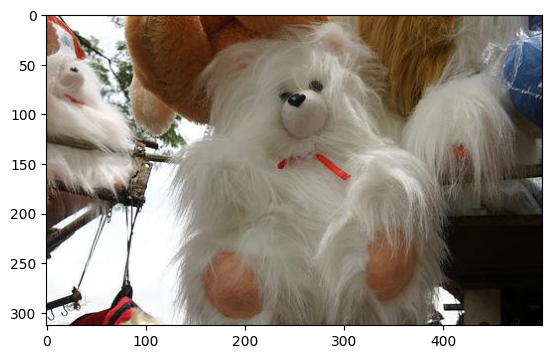

{'Food': {'tag': 'cake', 'score': 0.9295928478240967, 'index': 2},
 'Colors': {'tag': 'white', 'score': 0.9735645651817322, 'index': 1},
 'Location': {'tag': 'outdoor', 'score': 0.929412305355072, 'index': 1}}

In [24]:
plt.imshow(images[2])
plt.show()
tagger(images, threshold=0.9)[2]

In [25]:
subset_images = images[:123]
subset_labels = create_labels(tagger, subset_images, threshold=0.9)
optimize_model(tagger, subset_images, subset_labels, lr=1e-3, epochs=50, print_every=10)

Epoch: 0, Loss: 14.859752655029297
Epoch: 1, Loss: 13.737835884094238
Epoch: 2, Loss: 13.399182319641113
Epoch: 3, Loss: 13.282443046569824
Epoch: 4, Loss: 13.234975814819336
Epoch: 5, Loss: 13.213067054748535
Epoch: 6, Loss: 13.201921463012695
Epoch: 7, Loss: 13.19579029083252
Epoch: 8, Loss: 13.19218921661377
Epoch: 9, Loss: 13.189959526062012
Epoch: 10, Loss: 13.188512802124023
Epoch: 11, Loss: 13.18753433227539
Epoch: 12, Loss: 13.186854362487793
Epoch: 13, Loss: 13.186366081237793
Epoch: 14, Loss: 13.18600845336914
Epoch: 15, Loss: 13.185736656188965
Epoch: 16, Loss: 13.185531616210938
Epoch: 17, Loss: 13.185370445251465
Epoch: 18, Loss: 13.18524169921875
Epoch: 19, Loss: 13.185138702392578
Epoch: 20, Loss: 13.18505573272705
Epoch: 21, Loss: 13.18498706817627
Epoch: 22, Loss: 13.184930801391602
Epoch: 23, Loss: 13.184883117675781
Epoch: 24, Loss: 13.184844017028809
Epoch: 25, Loss: 13.184810638427734
Epoch: 26, Loss: 13.184781074523926
Epoch: 27, Loss: 13.184757232666016
Epoch: 28

Lets see the results after the optimization

reminder the task wasn't to currect the tags but to get better separation

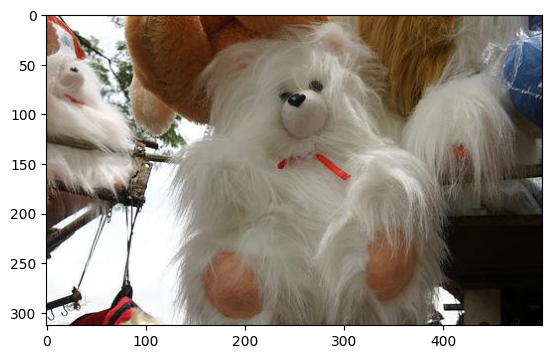

{'Animals': {'tag': 'dog', 'score': 0.9572145342826843, 'index': 0},
 'Sports': {'tag': 'flying', 'score': 0.9998077750205994, 'index': 6},
 'Living Beings': {'tag': 'animals', 'score': 0.9845950603485107, 'index': 0},
 'Food': {'tag': 'cake', 'score': 0.9999892711639404, 'index': 2},
 'Drink': {'tag': 'juice', 'score': 0.9999066591262817, 'index': 1},
 'Places': {'tag': 'natural settings',
  'score': 0.9554432034492493,
  'index': 0},
 'Nature & Weather': {'tag': 'nature',
  'score': 0.9995007514953613,
  'index': 0},
 'Colors': {'tag': 'white', 'score': 0.9999955892562866, 'index': 1},
 'Time & Season': {'tag': 'afternoon',
  'score': 0.9991312623023987,
  'index': 1},
 'Location': {'tag': 'outdoor', 'score': 0.9935698509216309, 'index': 1}}

In [26]:
plt.imshow(images[2])
plt.show()
tagger(images, threshold=0.9)[2]